In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.dataset import OzeDatasetWindow
from src.Transformer import Transformer

In [2]:
BATCH_SIZE = 2
NUM_WORKERS = 4
LR = 1e-2
EPOCHS = 5

K = 7 # Time window length
d_model = 48 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 4 # Number of heads
N = 4 # Number of encoder and decoder to stack

d_input = 37 # From dataset
d_output = 8 # From dataset

padding = 1

# Load dataset

In [3]:
dataloader = DataLoader(OzeDatasetWindow("dataset.npz", window_size=K, padding=padding),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS
                       )

# Load network

In [4]:
# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, K, N)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()

# Train

[Epoch   5/5]: 100%|██████████| 1000/1000 [04:15<00:00,  3.91it/s, loss=0.00902]


Loss: 0.009023


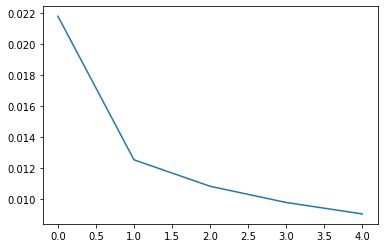

In [5]:
# Prepare loss history
hist_loss = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.reshape((-1, K, d_input)))
            netout = netout[:, padding:-padding, :]
            netout = netout.reshape((BATCH_SIZE, -1, K-2*padding, d_output))

            # Comupte loss
            loss = loss_function(netout, y)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(BATCH_SIZE)
        
    hist_loss[idx_epoch] = running_loss/len(dataloader)
plt.plot(hist_loss)
print(f"Loss: {float(hist_loss[-1]):5f}")

# Plot results sample

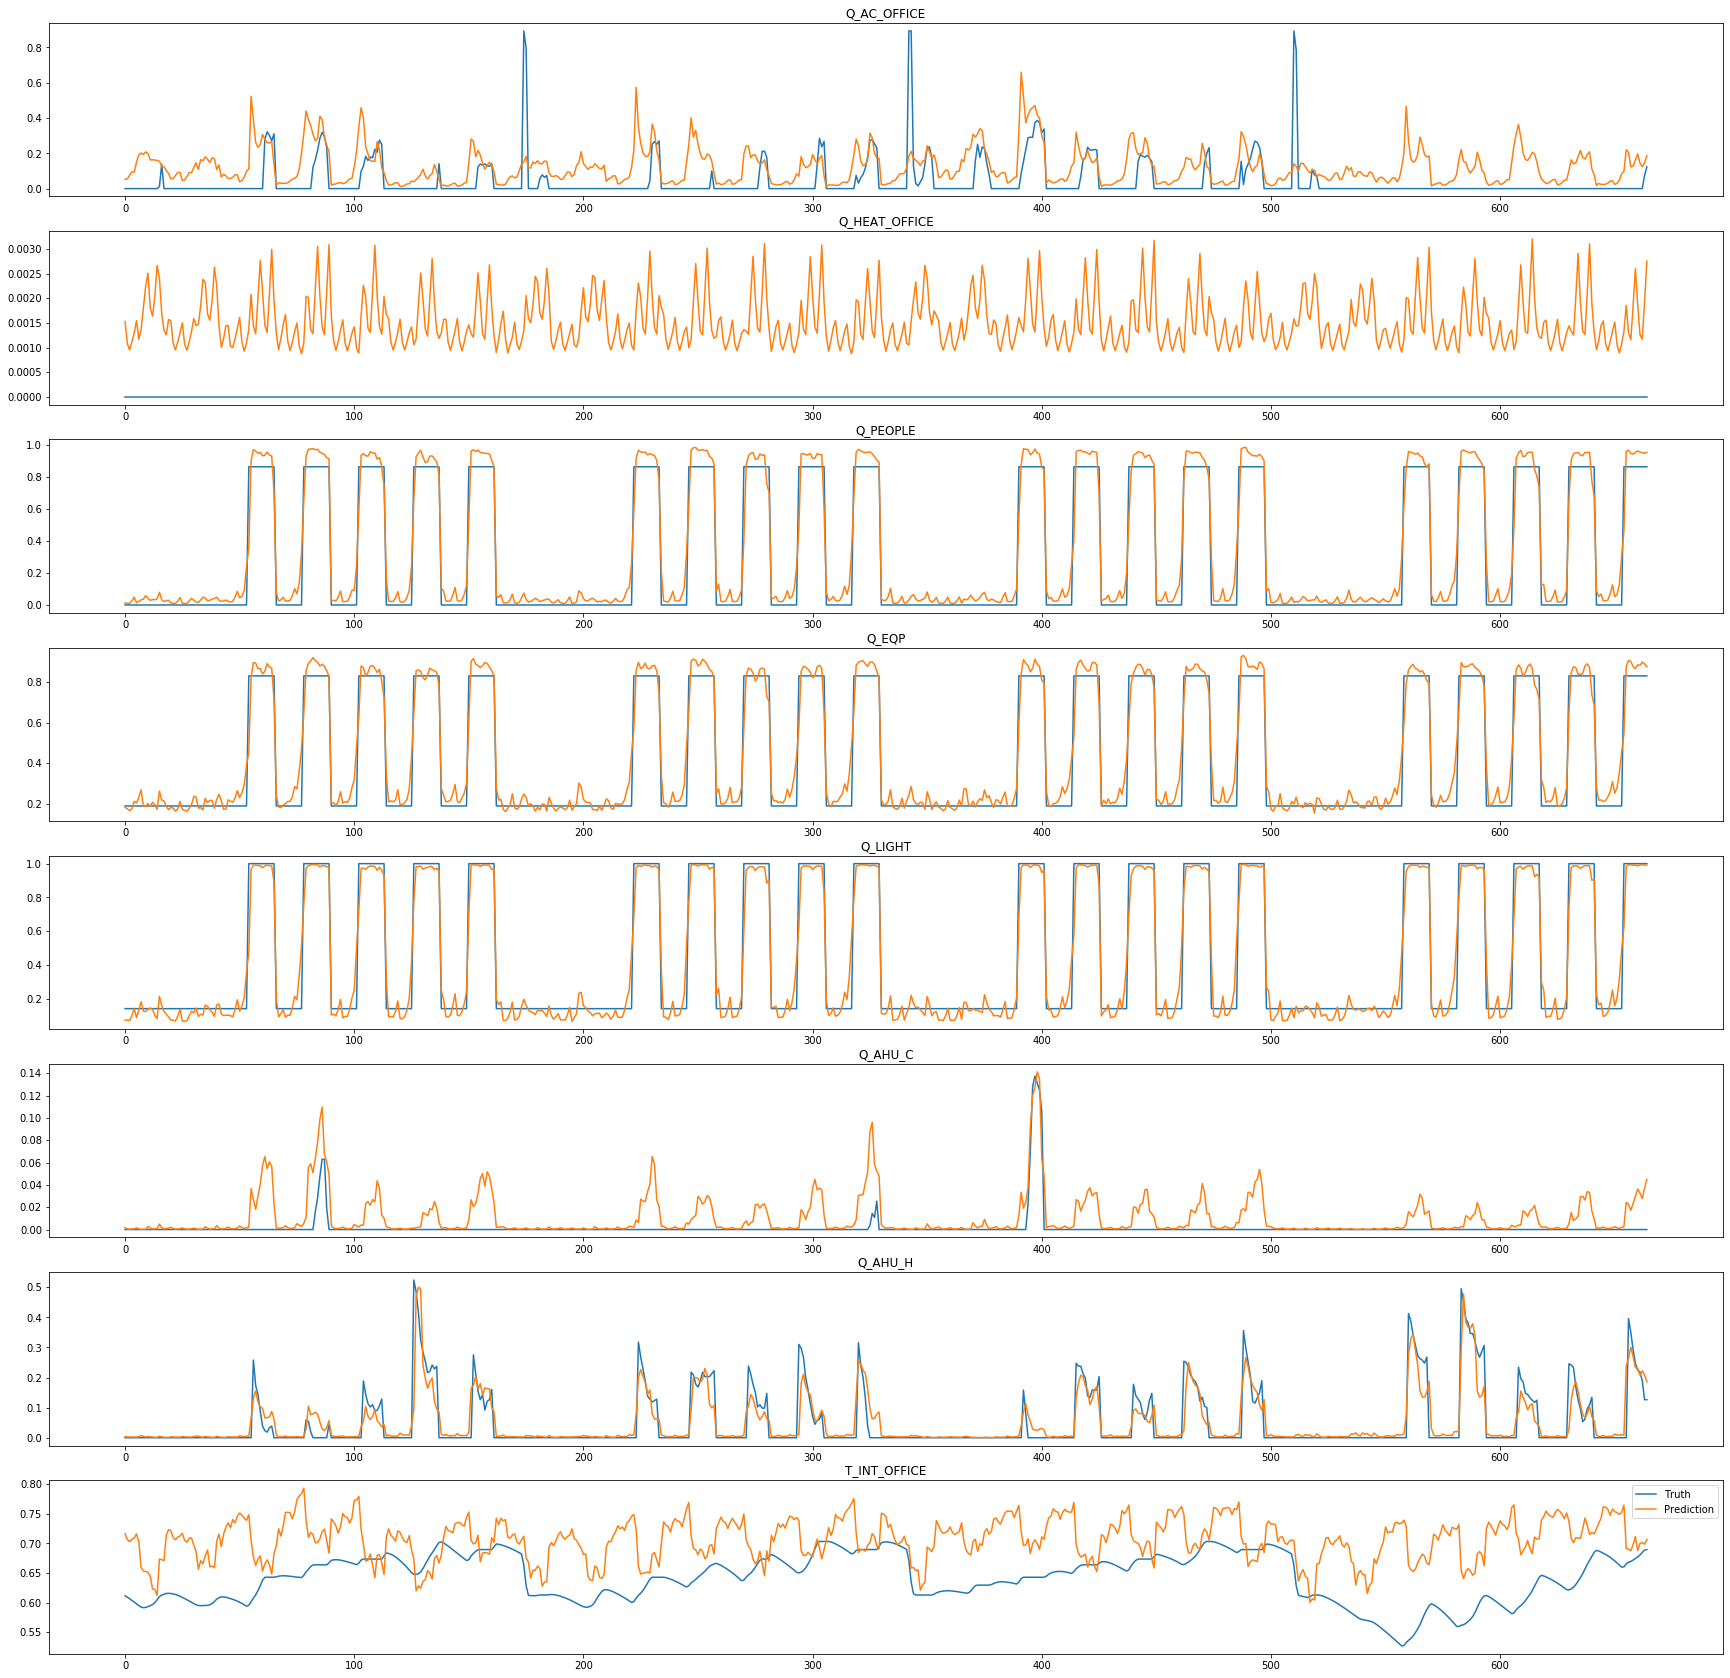

In [6]:
## Select training example
idx = np.random.randint(0, len(dataloader.dataset))
x, y = dataloader.dataset[idx]
y = y.reshape((-1, d_output))

# Run predictions
with torch.no_grad():
    x = torch.Tensor(x)
    netout = net(x)
    netout = netout[:, padding:-padding, :]
    netout = netout.reshape((-1, d_output))

plt.figure(figsize=(30, 30))
for idx_output_var in range(8):
    # Select real temperature
    y_true = y[:, idx_output_var]

    y_pred = netout[:, idx_output_var]
    y_pred = y_pred.numpy()

    plt.subplot(8, 1, idx_output_var+1)
    
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(dataloader.dataset.labels["X"][idx_output_var])
plt.legend()
plt.savefig("fig")